In [135]:
import cgranges
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

path = "output/post/S1/"
truth_tsv = f"{path}/truth.tsv"
CTs = open(truth_tsv).readline().rstrip("\n").split("\t")[1:-2]

In [136]:
def parse_intervals(intervals):
    return [tuple(map(int, interval.split("-"))) for interval in intervals.split(",")]


def parse_tsv(tsv):
    df = pd.read_csv(tsv, sep="\t")
    df["contig"] = df["contig"].astype(str)
    df["intervals"] = df["intervals"].apply(parse_intervals)
    df = df[df.apply(lambda x: len(x["intervals"]) > 1, axis=1)]
    df = pd.melt(
        df,
        id_vars=["transcript_id", "contig", "intervals"],
        value_vars=CTs,
        var_name="cell_type",
        value_name="count",
    )
    df = df[
        [
            "transcript_id",
            "cell_type",
            "count",
            "contig",
            "intervals",
        ]
    ]
    df = df[df["count"] > 0].sort_values("count", ascending=False).reset_index(drop=True)
    return df

In [137]:
truth_df = parse_tsv(truth_tsv)

truth_cg = cgranges.cgranges()
for idx, (contig, intervals, cell_type) in enumerate(
    zip(
        truth_df["contig"],
        truth_df["intervals"],
        truth_df["cell_type"],
    )
):
    for start, end in intervals:
        truth_cg.add(f"{cell_type}-{contig}", start, end, idx)
truth_cg.index()

In [138]:
def get_overlaps(pred_record):
    tidxs = set()
    contig = pred_record["contig"]
    cell_type = pred_record["cell_type"]
    for start, end in pred_record["intervals"]:
        for _, _, tidx in truth_cg.overlap(f"{cell_type}-{contig}", start, end):
            tidxs.add(tidx)
    return sorted(tidxs)


def fuzzy_match(A, B, slack=10):
    if len(A) != len(B):
        return False
    for (A_s, A_e), (B_s, B_e) in zip(A, B):
        if abs(B_s - A_s) > slack or abs(B_e - A_e) > slack:
            return False
    return True


def get_intronic_matches(pred_record):
    tidxs = list()
    for tidx in pred_record["overlap_tidxs"]:
        assert truth_df["contig"][tidx] == pred_record["contig"]
        if len(truth_df["intervals"][tidx]) == 1:
            continue
        A = truth_df["intervals"][tidx]
        B = pred_record["intervals"]
        A_introns = [(e1, s2) for (_, e1), (s2, _) in zip(A[:-1], A[1:])]
        B_introns = [(e1, s2) for (_, e1), (s2, _) in zip(B[:-1], B[1:])]
        if fuzzy_match(A_introns, B_introns):
            tidxs.append(tidx)
    return tidxs

In [198]:
pred_dfs = dict()
for tool in tqdm(
    [
        "freddie",
        "FLAMES_r1.00",
        "FLAMES_r0.75",
        "FLAMES_r0.50",
        "FLAMES_r0.25",
        "FLAMES_r0.01",
        "scNanoGPS_r1.00",
        "scNanoGPS_r0.75",
        "scNanoGPS_r0.50",
        "scNanoGPS_r0.25",
        "scNanoGPS_r0.01",
    ]
):
    try:
        pred_df = parse_tsv(f"{path}/{tool}.tsv")
        pred_df["overlap_tidxs"] = pred_df.apply(get_overlaps, axis=1)
        pred_df["intronic_match_tidxs"] = pred_df.apply(get_intronic_matches, axis=1)
    except:
        continue
    pred_dfs[tool] = pred_df

100%|██████████| 11/11 [00:17<00:00,  1.64s/it]


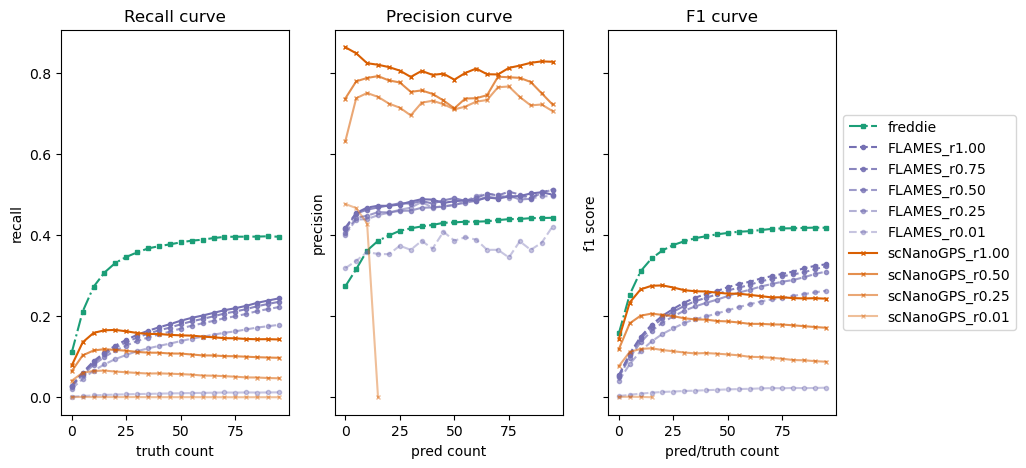

In [199]:
def styling(tool):
    D = dict()
    if tool.startswith("freddie"):
        D["linestyle"] = "-."
        D["marker"] = "s"
        D["color"] = "#1b9e77"
    elif tool.startswith("scNanoGPS"):
        D["linestyle"] = "-"
        D["marker"] = "x"
        D["color"] = "#d95f02"
        rate = float(tool.split("_")[1][1:])
        D["alpha"] = 0.4 + 0.6 * (rate - 0.01) / 0.99
    elif tool.startswith("FLAMES"):
        D["linestyle"] = "--"
        D["marker"] = "o"
        D["color"] = "#7570b3"
        rate = float(tool.split("_")[1][1:])
        D["alpha"] = 0.4 + 0.6 * (rate - 0.01) / 0.99
    D["markersize"] = 3
    return D


fig, axes = plt.subplots(1, 3, figsize=(10, 5), sharey=True)
axes[0].set_xlabel("truth count")
axes[0].set_ylabel("recall")
axes[0].set_title("Recall curve")
axes[1].set_xlabel("pred count")
axes[1].set_ylabel("precision")
axes[1].set_title("Precision curve")
axes[2].set_xlabel("pred/truth count")
axes[2].set_ylabel("f1 score")
axes[2].set_title("F1 curve")
R = list(range(0, 100, 5))
for tool, pred_df in pred_dfs.items():
    recall = np.zeros(len(truth_df), dtype=bool)
    for idx, tidxs in enumerate(pred_df["intronic_match_tidxs"]):
        for tidx in tidxs:
            recall[tidx] = True
    recall_curve = list()
    for count in R:
        num = np.sum(recall[truth_df["count"] >= count])
        den = np.sum(truth_df["count"] >= count)
        if den == 0:
            break
        recall_curve.append(num / den)
    axes[0].plot(R[: len(recall_curve)], recall_curve, label=tool, **styling(tool))

    precision = np.array(
        pred_df["intronic_match_tidxs"].apply(lambda x: len(x) > 0),
        dtype=bool,
    )
    precision_curve = list()
    for count in R:
        num = np.sum(precision[pred_df["count"] >= count])
        den = np.sum(pred_df["count"] >= count)
        if den == 0:
            break
        precision_curve.append(num / den)
    axes[1].plot(R[: len(precision_curve)], precision_curve, label=tool, **styling(tool))

    min_len = min(len(recall_curve), len(precision_curve))
    recall_curve = recall_curve[:min_len]
    precision_curve = precision_curve[:min_len]
    f1_curve = 2 * (np.array(precision_curve) * np.array(recall_curve)) / (
        np.array(precision_curve) + np.array(recall_curve)
    )
    axes[2].plot(R[: len(f1_curve)], f1_curve, label=tool, **styling(tool))
# legend outside of plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()